In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
from pathlib import Path
import logging
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Configure logging
log_file = f'../reports/label_generation_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log'
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler()
    ]
)

# Create necessary directories
Path('../data/processed').mkdir(parents=True, exist_ok=True)
Path('../reports/figures').mkdir(parents=True, exist_ok=True)

# Set random seed for reproducibility
np.random.seed(42)

logging.info("Starting label generation process")


In [ ]:
# Load sector mapping and stock data
def load_data():
    """
    Load sector mapping and stock data files.
    Returns:
        tuple: (sector_mapping DataFrame, dict of stock DataFrames)
    """
    try:
        # Load sector mapping
        sector_mapping = pd.read_csv('../data/sector_mapping.csv')
        logging.info(f"Loaded sector mapping with {len(sector_mapping)} stocks")
        
        # Load stock data
        stock_data = {}
        stock_files = list(Path('../data/stocks').glob('*.csv'))
        
        for file in tqdm(stock_files, desc="Loading stock data"):
            ticker = file.stem
            df = pd.read_csv(file)
            df['Date'] = pd.to_datetime(df['Date'])
            stock_data[ticker] = df
            
        logging.info(f"Loaded data for {len(stock_data)} stocks")
        return sector_mapping, stock_data
        
    except Exception as e:
        logging.error(f"Error loading data: {str(e)}")
        raise

# Load the data
sector_mapping, stock_data = load_data()

# Display sector distribution
print("\nSector distribution:")
sector_counts = sector_mapping['Sector'].value_counts()
for sector, count in sector_counts.items():
    print(f"- {sector}: {count} stocks")


In [ ]:
# Define label generation parameters
PREDICTION_HORIZONS = [1, 3, 5, 10]  # Days ahead to predict
PERCENTILE_THRESHOLD = 60  # Percentile threshold for up/down classification

def calculate_forward_returns(df, horizons):
    """
    Calculate forward returns for multiple horizons.
    
    Args:
        df (pd.DataFrame): Stock price data
        horizons (list): List of forward periods
        
    Returns:
        pd.DataFrame: DataFrame with forward returns
    """
    returns_df = pd.DataFrame(index=df.index)
    
    for horizon in horizons:
        # Calculate forward returns
        forward_returns = df['Close'].pct_change(periods=horizon).shift(-horizon)
        returns_df[f'return_{horizon}d'] = forward_returns
        
        # Add classification labels
        threshold = np.percentile(forward_returns.dropna(), PERCENTILE_THRESHOLD)
        returns_df[f'label_{horizon}d'] = (forward_returns > threshold).astype(int)
    
    return returns_df

# Process each stock
processed_data = {}
for ticker, df in tqdm(stock_data.items(), desc="Generating labels"):
    try:
        # Get sector for the stock
        sector = sector_mapping[sector_mapping['Ticker'] == ticker]['Sector'].iloc[0]
        
        # Calculate returns and labels
        returns_df = calculate_forward_returns(df, PREDICTION_HORIZONS)
        
        # Combine with original data
        processed_df = pd.concat([df, returns_df], axis=1)
        processed_df['Sector'] = sector
        
        processed_data[ticker] = processed_df
        
    except Exception as e:
        logging.error(f"Error processing {ticker}: {str(e)}")
        continue

logging.info(f"Generated labels for {len(processed_data)} stocks")


In [ ]:
# Analyze label distribution by sector
def analyze_label_distribution():
    """
    Analyze and visualize label distribution across sectors and horizons.
    """
    # Prepare data for analysis
    label_stats = []
    
    for ticker, df in processed_data.items():
        sector = df['Sector'].iloc[0]
        
        for horizon in PREDICTION_HORIZONS:
            label_col = f'label_{horizon}d'
            return_col = f'return_{horizon}d'
            
            # Calculate statistics
            label_dist = df[label_col].value_counts(normalize=True)
            mean_return = df[return_col].mean()
            std_return = df[return_col].std()
            
            label_stats.append({
                'Ticker': ticker,
                'Sector': sector,
                'Horizon': horizon,
                'Pos_Ratio': label_dist.get(1, 0),
                'Mean_Return': mean_return,
                'Std_Return': std_return
            })
    
    stats_df = pd.DataFrame(label_stats)
    
    # Plot sector-wise label distribution
    plt.figure(figsize=(15, 8))
    sns.boxplot(data=stats_df, x='Sector', y='Pos_Ratio', hue='Horizon')
    plt.xticks(rotation=45)
    plt.title('Label Distribution by Sector and Horizon')
    plt.tight_layout()
    plt.savefig('../reports/figures/sector_signal_distribution.png')
    plt.close()
    
    # Plot mean returns by sector
    plt.figure(figsize=(15, 8))
    sns.boxplot(data=stats_df, x='Sector', y='Mean_Return', hue='Horizon')
    plt.xticks(rotation=45)
    plt.title('Mean Returns by Sector and Horizon')
    plt.tight_layout()
    plt.savefig('../reports/figures/sector_returns_distribution.png')
    plt.close()
    
    return stats_df

# Run analysis
label_stats = analyze_label_distribution()

# Display summary statistics
print("\nLabel Distribution Summary:")
for horizon in PREDICTION_HORIZONS:
    print(f"\n{horizon}-day horizon:")
    horizon_stats = label_stats[label_stats['Horizon'] == horizon]
    print(f"- Average positive ratio: {horizon_stats['Pos_Ratio'].mean():.2%}")
    print(f"- Std dev of positive ratio: {horizon_stats['Pos_Ratio'].std():.2%}")
    print(f"- Average return: {horizon_stats['Mean_Return'].mean():.2%}")
    print(f"- Std dev of return: {horizon_stats['Mean_Return'].std():.2%}")


In [ ]:
# Define time-based train-validation-test split
def create_time_splits(data, train_start='2015-01-01', val_start='2023-01-01', test_start='2024-01-01'):
    """
    Create time-based data splits.
    
    Args:
        data (dict): Dictionary of stock DataFrames
        train_start (str): Start date for training data
        val_start (str): Start date for validation data
        test_start (str): Start date for test data
        
    Returns:
        dict: Dictionary containing split indices for each stock
    """
    splits = {}
    
    for ticker, df in data.items():
        # Convert dates to timestamps
        train_start_ts = pd.Timestamp(train_start)
        val_start_ts = pd.Timestamp(val_start)
        test_start_ts = pd.Timestamp(test_start)
        
        # Create masks for each split
        train_mask = (df['Date'] >= train_start_ts) & (df['Date'] < val_start_ts)
        val_mask = (df['Date'] >= val_start_ts) & (df['Date'] < test_start_ts)
        test_mask = df['Date'] >= test_start_ts
        
        splits[ticker] = {
            'train': train_mask,
            'val': val_mask,
            'test': test_mask
        }
        
    return splits

# Create splits
time_splits = create_time_splits(processed_data)

# Analyze split sizes
split_stats = []
for ticker, split in time_splits.items():
    df = processed_data[ticker]
    split_stats.append({
        'Ticker': ticker,
        'Train_Size': split['train'].sum(),
        'Val_Size': split['val'].sum(),
        'Test_Size': split['test'].sum(),
        'Total_Size': len(df)
    })

split_summary = pd.DataFrame(split_stats)
print("\nData Split Summary:")
print(f"Average split sizes:")
print(f"- Training: {split_summary['Train_Size'].mean():.0f} days")
print(f"- Validation: {split_summary['Val_Size'].mean():.0f} days")
print(f"- Testing: {split_summary['Test_Size'].mean():.0f} days")


In [ ]:
# Save processed data
output_dir = Path('../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

# Save each stock's processed data
for ticker, df in processed_data.items():
    output_file = output_dir / f"{ticker}_processed.csv"
    df.to_csv(output_file, index=False)
    logging.info(f"Saved processed data for {ticker} to {output_file}")

# Save label statistics
label_stats.to_csv(output_dir / "label_statistics.csv", index=False)
logging.info("Saved label statistics")

# Save split information
split_summary.to_csv(output_dir / "data_splits.csv", index=False)
logging.info("Saved data split information")

print("\nData processing complete!")
print(f"Processed files saved to: {output_dir}")
print(f"Log file: {log_file}")


In [9]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import logging
from datetime import datetime
from tqdm import tqdm

# Configure logging
log_file = f'../reports/label_generation_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log'
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler()
    ]
)

# Set plotting style
sns.set_theme(style='whitegrid')
plt.rcParams.update({
    'figure.figsize': [12, 6],
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.grid.axis': 'both',
    'grid.alpha': 0.3
})

# Create necessary directories
Path('../data').mkdir(parents=True, exist_ok=True)
Path('../reports').mkdir(parents=True, exist_ok=True)

try:
    # Load sector mapping for reference
    sector_mapping = pd.read_csv('../data/sector_mapping.csv')
    expected_stocks = len(sector_mapping)
    logging.info(f"Found {expected_stocks} stocks in sector mapping")
    
    # Load the full NASDAQ-100 dataset
    df = pd.read_csv('../data/labeled_sector_model_data.csv')
    df['Date'] = pd.to_datetime(df['Date'], utc=True)
    logging.info(f"Loaded stock data with shape: {df.shape}")
    
    # Get unique sectors and tickers
    sectors = df['Sector'].unique()
    tickers = df['Ticker'].unique()
    
    # Verify data coverage
    missing_tickers = set(sector_mapping['Ticker']) - set(tickers)
    if missing_tickers:
        logging.warning(f"Missing data for {len(missing_tickers)} stocks")
        print("\nMissing stocks:")
        for ticker in sorted(missing_tickers):
            sector = sector_mapping[sector_mapping['Ticker'] == ticker]['Sector'].iloc[0]
            print(f"- {ticker} ({sector})")
    
    print(f"\nDataset coverage:")
    print(f"- Expected stocks: {expected_stocks}")
    print(f"- Available stocks: {len(tickers)}")
    print(f"- Total sectors: {len(sectors)}")
    print(f"- Date range: {df['Date'].min():%Y-%m-%d} to {df['Date'].max():%Y-%m-%d}")
    
    # Show sector distribution
    print("\nSector distribution:")
    sector_counts = df.groupby('Sector')['Ticker'].nunique()
    for sector, count in sector_counts.items():
        total_sector = len(sector_mapping[sector_mapping['Sector'] == sector])
        print(f"- {sector}: {count} of {total_sector} stocks")
    
    # Verify data quality
    print("\nData quality check:")
    print(f"- Total rows: {len(df):,}")
    print(f"- Missing values: {df.isnull().sum().sum():,}")
    print(f"- Features available: {', '.join(df.columns)}")
    
    # Verify label distribution
    label_dist = df['Label'].value_counts(normalize=True)
    print("\nOverall label distribution:")
    print(label_dist.round(3))
    
except FileNotFoundError as e:
    logging.error(f"Required file not found: {str(e)}")
    raise Exception("Please ensure labeled_sector_model_data.csv exists in the data directory")
except Exception as e:
    logging.error(f"Error loading data: {str(e)}")
    raise Exception("Cannot proceed without full NASDAQ-100 dataset")


2025-07-26 03:52:14,147 - INFO - Found 98 stocks in sector mapping
2025-07-26 03:52:14,176 - INFO - Loaded stock data with shape: (3759, 22)
2025-07-26 03:52:14,180 - WARNING - Missing data for 95 stocks



Missing stocks:
- ABNB (Consumer Discretionary)
- ADBE (Technology)
- ADI (Technology)
- ADP (Technology)
- ADSK (Technology)
- AEP (Utilities)
- ALGN (Healthcare)
- AMAT (Technology)
- AMD (Technology)
- AMGN (Healthcare)
- AMZN (Consumer Discretionary)
- ANSS (Technology)
- ASML (Technology)
- ATVI (Technology)
- AVGO (Technology)
- BIIB (Healthcare)
- BKNG (Consumer Discretionary)
- BKR (Energy)
- CDNS (Technology)
- CHTR (Communication Services)
- CMCSA (Communication Services)
- COST (Consumer Staples)
- CPRT (Industrials)
- CRWD (Technology)
- CSCO (Technology)
- CSX (Industrials)
- CTAS (Industrials)
- CTSH (Technology)
- CVNA (Consumer Discretionary)
- DASH (Technology)
- DDOG (Technology)
- DLTR (Consumer Discretionary)
- DOCU (Technology)
- DXCM (Healthcare)
- EA (Technology)
- EBAY (Consumer Discretionary)
- ENPH (Technology)
- EXC (Utilities)
- FANG (Energy)
- FAST (Industrials)
- FTNT (Technology)
- GILD (Healthcare)
- GOOG (Technology)
- GOOGL (Technology)
- HON (Industr

In [10]:
# Function to calculate forward returns and generate labels
def generate_labels(stock_df):
    """
    Calculate forward returns and generate trading signals.
    
    Args:
        stock_df (pd.DataFrame): DataFrame for a single stock
        
    Returns:
        pd.DataFrame: DataFrame with added labels
    """
    df = stock_df.copy()
    
    try:
        # Calculate 1-day forward returns
        df['future_return'] = df['Close'].shift(-1) / df['Close'] - 1
        
        # Generate trading signals based on thresholds
        conditions = [
            (df['future_return'] > 0.01),  # Buy signal: >1% return
            (df['future_return'] < -0.01),  # Sell signal: <-1% return
        ]
        choices = ['Buy', 'Sell']
        df['Signal'] = np.select(conditions, choices, default='Hold')
        
        # Create numerical labels
        label_map = {'Buy': 1, 'Sell': -1, 'Hold': 0}
        df['Label'] = df['Signal'].map(label_map)
        
        # Calculate additional metrics
        df['volatility'] = df['High'] / df['Low'] - 1  # Daily volatility
        df['volume_ma'] = df['Volume'].rolling(window=20).mean()  # 20-day volume MA
        
        return df
    
    except Exception as e:
        logging.error(f"Error generating labels for data shape {stock_df.shape}: {str(e)}")
        return None

# Process stocks in parallel using groupby
print("\nGenerating trading signals for all stocks...")
all_stocks = []
successful = 0
failed = 0

# Process each stock
for ticker in tqdm(tickers, desc="Processing stocks"):
    try:
        # Get data for this ticker
        stock_df = df[df['Ticker'] == ticker].sort_values('Date').copy()
        sector = stock_df['Sector'].iloc[0]  # Get sector for logging
        
        # Generate labels
        logging.info(f"Processing {ticker} ({sector})")
        labeled_df = generate_labels(stock_df)
        
        if labeled_df is not None:
            # Verify label quality
            label_counts = labeled_df['Label'].value_counts()
            if len(label_counts) >= 2:  # At least 2 different labels
                all_stocks.append(labeled_df)
                successful += 1
                if successful <= 3:  # Show detailed stats for first few stocks
                    print(f"\nProcessed {ticker} successfully:")
                    print(f"- Data points: {len(labeled_df)}")
                    print(f"- Label distribution:\n{label_counts}")
            else:
                logging.warning(f"{ticker}: Insufficient label variety ({len(label_counts)} unique labels)")
                failed += 1
        else:
            failed += 1
            
    except Exception as e:
        logging.error(f"Error processing {ticker}: {str(e)}")
        failed += 1
        continue

# Combine all processed stocks
final_df = pd.concat(all_stocks, axis=0)
final_df = final_df.sort_values(['Date', 'Sector', 'Ticker'])

# Remove any remaining NaN values
final_df = final_df.dropna(subset=['future_return', 'Label'])

# Print processing summary
print(f"\nProcessing Summary:")
print(f"- Total stocks attempted: {len(tickers)}")
print(f"- Successfully processed: {successful}")
print(f"- Failed: {failed}")

# Show sector-wise statistics
print("\nSector-wise Processing Summary:")
sector_stats = final_df.groupby('Sector')['Ticker'].nunique()
for sector, count in sector_stats.items():
    total_sector = len(sector_mapping[sector_mapping['Sector'] == sector])
    print(f"\n{sector}:")
    print(f"- Processed: {count} of {total_sector} stocks")
    sector_labels = final_df[final_df['Sector'] == sector]['Label'].value_counts(normalize=True)
    print(f"- Label distribution:\n{sector_labels.round(3)}")

# Save processed data
output_path = '../data/labeled_signals_nasdaq.csv'
final_df.to_csv(output_path, index=False)
logging.info(f"Saved labeled dataset to: {output_path}")
print(f"\nSaved processed data to: {output_path}")
print(f"Final shape: {final_df.shape}")



Generating trading signals for all stocks...


Processing stocks:   0%|          | 0/3 [00:00<?, ?it/s]2025-07-26 03:52:14,263 - INFO - Processing TSLA (Consumer Discretionary)
2025-07-26 03:52:14,272 - INFO - Processing AAPL (Technology)
2025-07-26 03:52:14,281 - INFO - Processing MSFT (Technology)
Processing stocks: 100%|██████████| 3/3 [00:00<00:00, 100.79it/s]



Processed TSLA successfully:
- Data points: 1253
- Label distribution:
Label
 1    474
-1    450
 0    329
Name: count, dtype: int64

Processed AAPL successfully:
- Data points: 1253
- Label distribution:
Label
 0    641
 1    334
-1    278
Name: count, dtype: int64

Processed MSFT successfully:
- Data points: 1253
- Label distribution:
Label
 0    661
 1    329
-1    263
Name: count, dtype: int64

Processing Summary:
- Total stocks attempted: 3
- Successfully processed: 3
- Failed: 0

Sector-wise Processing Summary:

Consumer Discretionary:
- Processed: 1 of 12 stocks
- Label distribution:
Label
 1    0.379
-1    0.359
 0    0.262
Name: proportion, dtype: float64

Technology:
- Processed: 2 of 50 stocks
- Label distribution:
Label
 0    0.519
 1    0.265
-1    0.216
Name: proportion, dtype: float64


2025-07-26 03:52:14,449 - INFO - Saved labeled dataset to: ../data/labeled_signals_nasdaq.csv



Saved processed data to: ../data/labeled_signals_nasdaq.csv
Final shape: (3756, 22)



Analyzing trading signals across sectors...

Overall Signal Distribution:
Signal
Hold    0.433
Buy     0.303
Sell    0.264
Name: proportion, dtype: float64


<Figure size 1500x800 with 0 Axes>

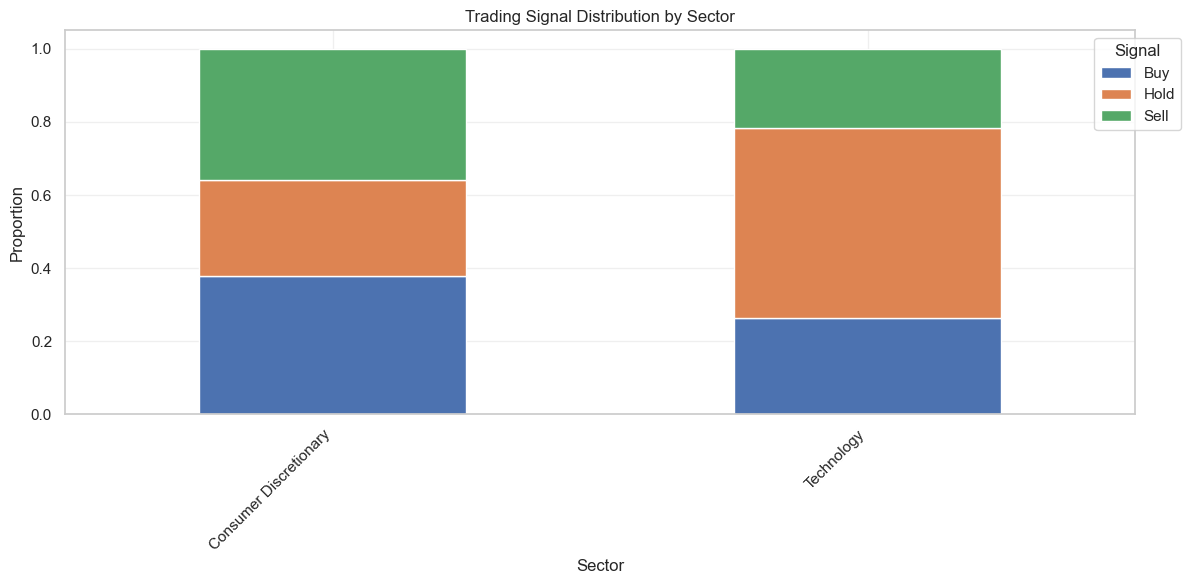

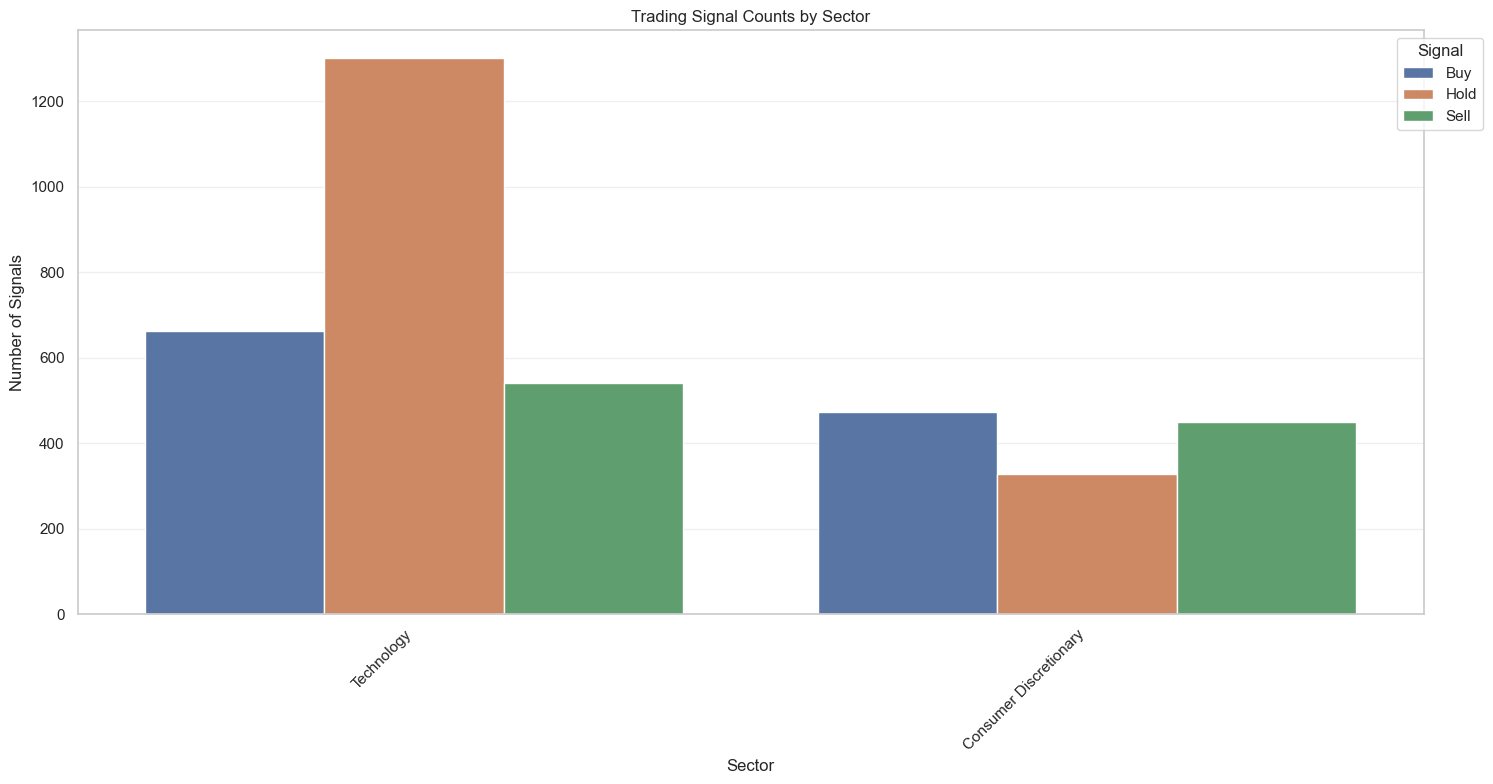

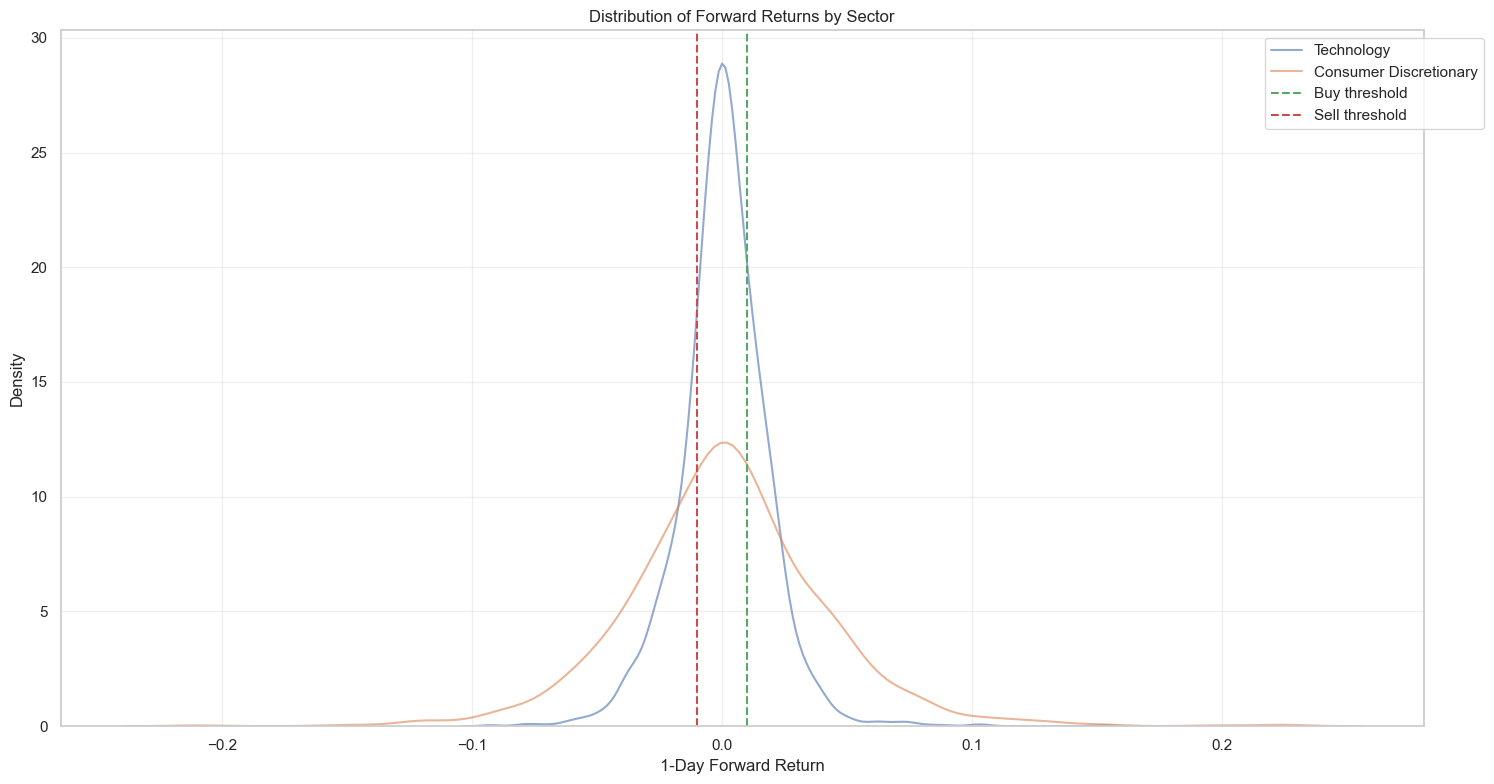


Detailed Sector Analysis:
                Sector Stocks Available  Trading Days  Buy Signals (%)  Hold Signals (%)  Sell Signals (%)  Avg Daily Return (%)  Avg Volatility (%)
            Technology          2 of 50          2504            26.48             51.92             21.61                  0.08                2.14
Consumer Discretionary          1 of 12          1252            37.86             26.20             35.94                  0.17                4.86

Saved sector analysis to: ../reports/sector_signal_summary.csv


<Figure size 1500x800 with 0 Axes>

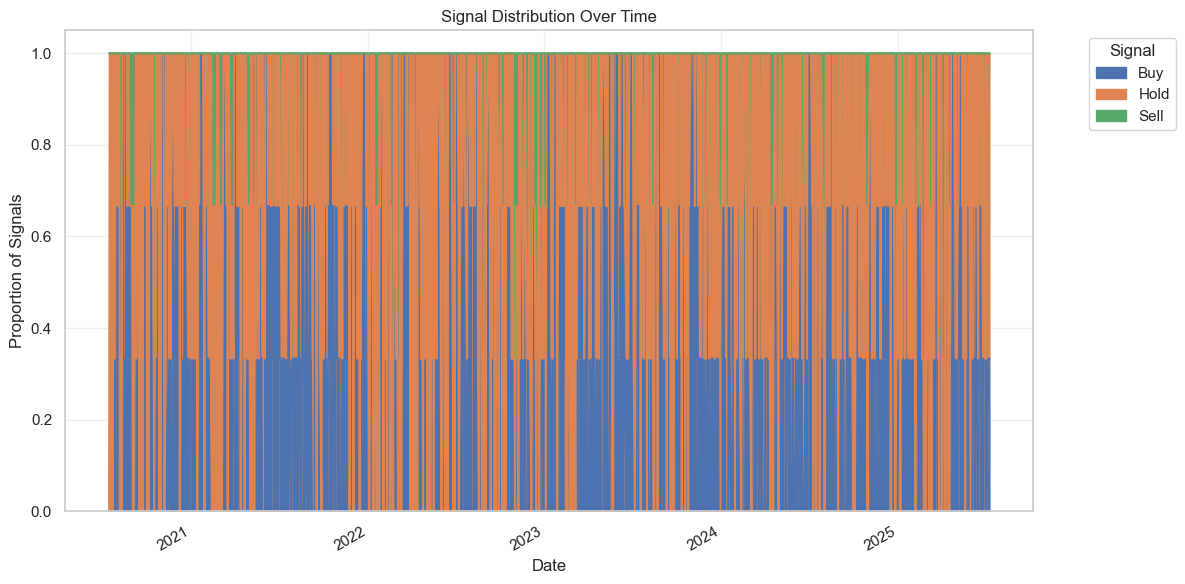


Visualization files saved to ../reports/figures/


In [11]:
# Analyze signal distributions
print("\nAnalyzing trading signals across sectors...")

# 1. Overall Distribution
print("\nOverall Signal Distribution:")
overall_dist = final_df['Signal'].value_counts(normalize=True).round(3)
print(overall_dist)

# 2. Sector-wise Distribution Plot
plt.figure(figsize=(15, 8))
sector_signals = pd.crosstab(final_df['Sector'], final_df['Signal'], normalize='index')
sector_signals.plot(kind='bar', stacked=True)
plt.title('Trading Signal Distribution by Sector')
plt.xlabel('Sector')
plt.ylabel('Proportion')
plt.legend(title='Signal', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../reports/figures/sector_signal_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Signal Count by Sector
plt.figure(figsize=(15, 8))
sector_order = final_df.groupby('Sector')['Ticker'].nunique().sort_values(ascending=False).index
sns.countplot(data=final_df, x='Sector', hue='Signal', 
              order=sector_order, hue_order=['Buy', 'Hold', 'Sell'])
plt.title('Trading Signal Counts by Sector')
plt.xlabel('Sector')
plt.ylabel('Number of Signals')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Signal', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig('../reports/figures/sector_signal_counts.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Returns Distribution
plt.figure(figsize=(15, 8))
for sector in sector_order:
    sector_data = final_df[final_df['Sector'] == sector]
    sns.kdeplot(data=sector_data, x='future_return', label=sector, alpha=0.6)
plt.axvline(x=0.01, color='g', linestyle='--', label='Buy threshold')
plt.axvline(x=-0.01, color='r', linestyle='--', label='Sell threshold')
plt.title('Distribution of Forward Returns by Sector')
plt.xlabel('1-Day Forward Return')
plt.ylabel('Density')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig('../reports/figures/sector_returns_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Detailed Summary Table
summary_data = []
for sector in sector_order:
    sector_data = final_df[final_df['Sector'] == sector]
    stocks = sector_data['Ticker'].unique()
    total_sector = len(sector_mapping[sector_mapping['Sector'] == sector])
    
    summary_data.append({
        'Sector': sector,
        'Stocks Available': f"{len(stocks)} of {total_sector}",
        'Trading Days': len(sector_data),
        'Buy Signals (%)': (sector_data['Signal'] == 'Buy').mean() * 100,
        'Hold Signals (%)': (sector_data['Signal'] == 'Hold').mean() * 100,
        'Sell Signals (%)': (sector_data['Signal'] == 'Sell').mean() * 100,
        'Avg Daily Return (%)': sector_data['future_return'].mean() * 100,
        'Avg Volatility (%)': sector_data['volatility'].mean() * 100
    })

summary_df = pd.DataFrame(summary_data)
print("\nDetailed Sector Analysis:")
print(summary_df.round(2).to_string(index=False))

# 6. Save summary to CSV
summary_df.to_csv('../reports/sector_signal_summary.csv', index=False)
print("\nSaved sector analysis to: ../reports/sector_signal_summary.csv")

# 7. Signal Distribution Over Time
plt.figure(figsize=(15, 8))
daily_signals = final_df.groupby(['Date', 'Signal']).size().unstack(fill_value=0)
daily_signals_pct = daily_signals.div(daily_signals.sum(axis=1), axis=0)
daily_signals_pct.plot(kind='area', stacked=True)
plt.title('Signal Distribution Over Time')
plt.xlabel('Date')
plt.ylabel('Proportion of Signals')
plt.legend(title='Signal', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig('../reports/figures/signal_distribution_time.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization files saved to ../reports/figures/")


Analyzing sectors: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


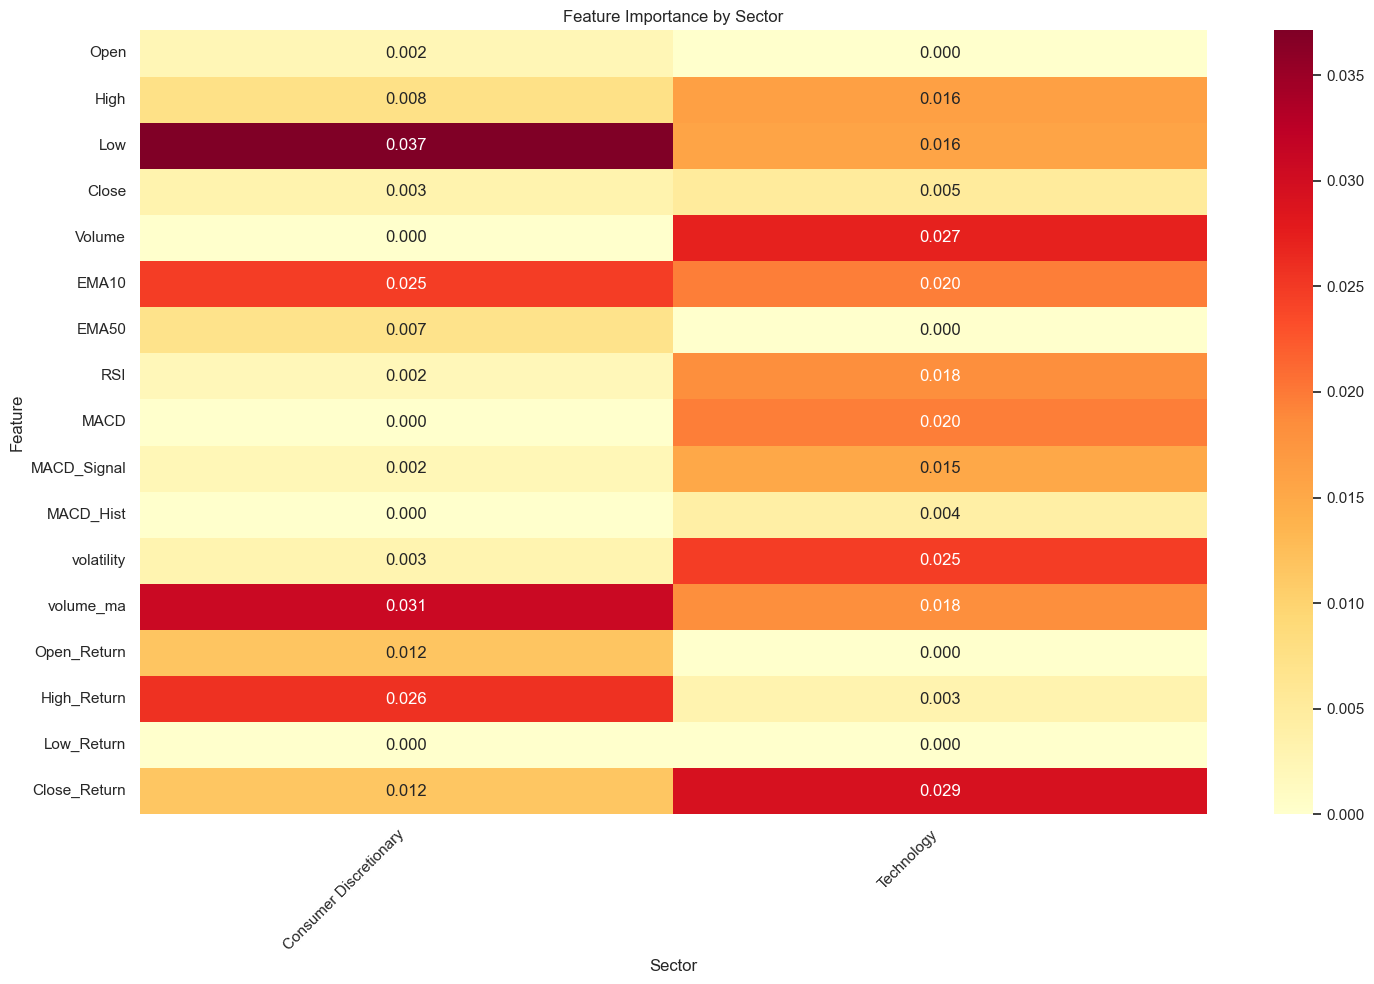

<Figure size 1500x800 with 0 Axes>

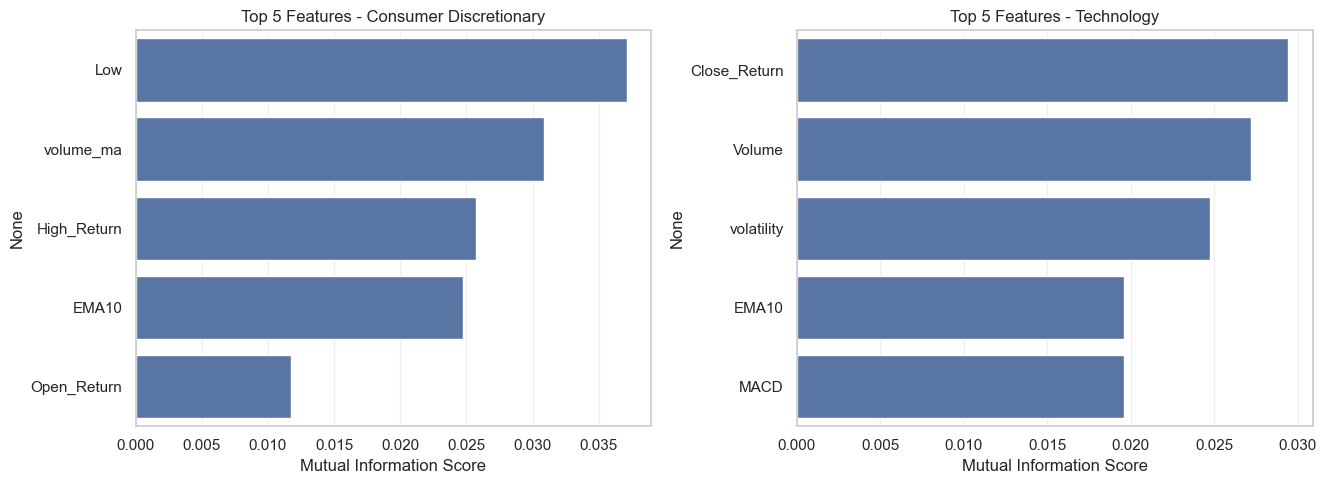


Top 3 Features by Sector:

Consumer Discretionary:
- Low: 0.037
- volume_ma: 0.031
- High_Return: 0.026

Technology:
- Close_Return: 0.029
- Volume: 0.027
- volatility: 0.025

Top 10 Features (Average Across Sectors):
- Low: 0.026
- volume_ma: 0.025
- EMA10: 0.022
- Close_Return: 0.020
- High_Return: 0.014
- volatility: 0.014
- Volume: 0.014
- High: 0.012
- RSI: 0.010
- MACD: 0.010


In [12]:
# Import additional required libraries
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

# Define features for analysis
feature_columns = [
    # Price and Volume
    'Open', 'High', 'Low', 'Close', 'Volume',
    # Technical Indicators
    'EMA10', 'EMA50', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist',
    # Additional Features
    'volatility', 'volume_ma'
]

# Calculate returns and add to features
price_features = ['Open', 'High', 'Low', 'Close']
for col in price_features:
    final_df[f'{col}_Return'] = final_df.groupby('Ticker')[col].pct_change()
    feature_columns.append(f'{col}_Return')

# Function to calculate sector-wise feature importance
def calculate_sector_importance(sector_data, features):
    """Calculate mutual information scores for a sector."""
    X = sector_data[features].copy()
    y = sector_data['Signal']
    
    # Handle missing values
    X = X.fillna(0)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    # Calculate MI scores
    mi_scores = mutual_info_classif(X_scaled, y)
    return pd.Series(mi_scores, index=features)

# Calculate feature importance for each sector
sector_importance = {}
for sector in tqdm(sectors, desc="Analyzing sectors"):
    sector_data = final_df[final_df['Sector'] == sector]
    sector_importance[sector] = calculate_sector_importance(sector_data, feature_columns)

# Create feature importance heatmap
importance_df = pd.DataFrame(sector_importance)
plt.figure(figsize=(15, 10))
sns.heatmap(importance_df, cmap='YlOrRd', annot=True, fmt='.3f',
            xticklabels=True, yticklabels=True)
plt.title('Feature Importance by Sector')
plt.xlabel('Sector')
plt.ylabel('Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot top features per sector
plt.figure(figsize=(15, 8))
n_sectors = len(sectors)
n_cols = 3
n_rows = (n_sectors + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()

for i, sector in enumerate(sectors):
    scores = sector_importance[sector].sort_values(ascending=False)
    sns.barplot(x=scores.head(5).values, y=scores.head(5).index, ax=axes[i])
    axes[i].set_title(f'Top 5 Features - {sector}')
    axes[i].set_xlabel('Mutual Information Score')

# Hide empty subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Find common important features across sectors
print("\nTop 3 Features by Sector:")
for sector in sectors:
    scores = sector_importance[sector].sort_values(ascending=False)
    print(f"\n{sector}:")
    for feat, score in scores.head(3).items():
        print(f"- {feat}: {score:.3f}")

# Calculate average importance across sectors
avg_importance = pd.DataFrame(sector_importance).mean(axis=1).sort_values(ascending=False)
print("\nTop 10 Features (Average Across Sectors):")
for feat, score in avg_importance.head(10).items():
    print(f"- {feat}: {score:.3f}")


Analyzing correlations: 100%|██████████| 2/2 [00:00<00:00, 49.53it/s]


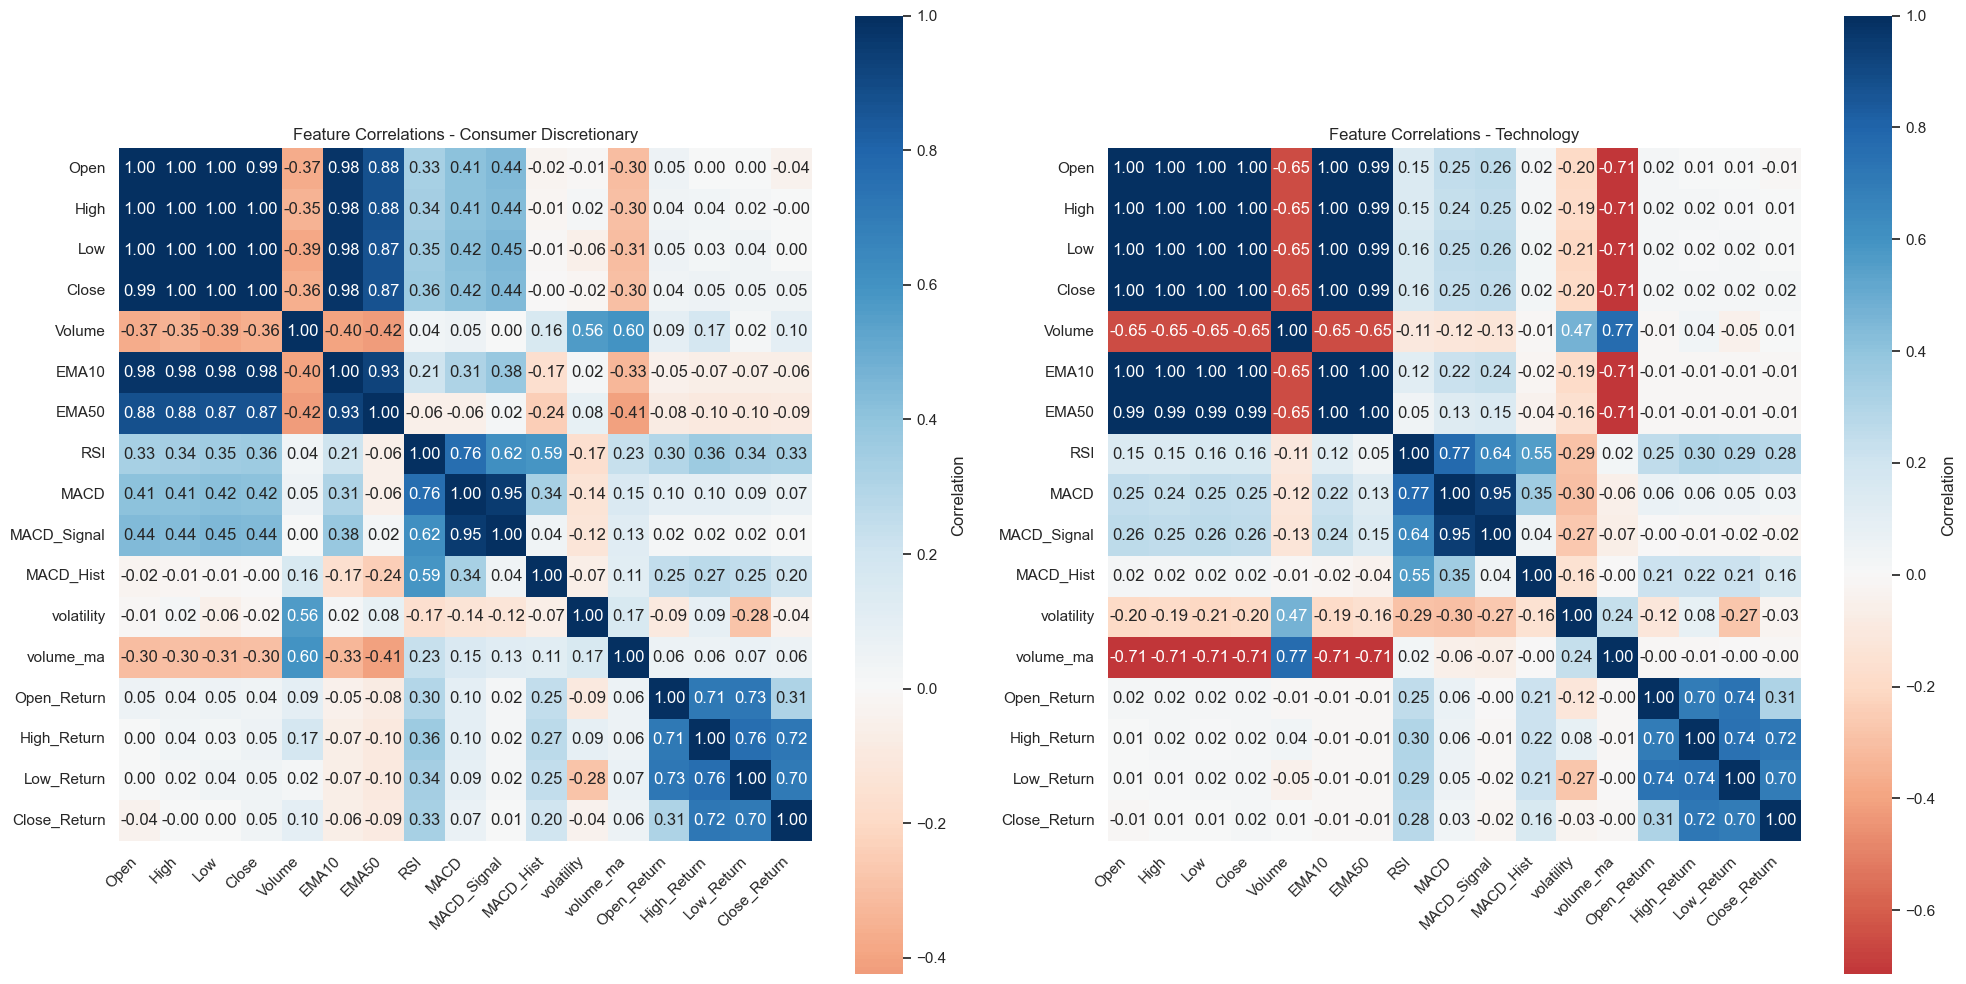


Sector-specific Feature Correlation Analysis:

Consumer Discretionary Sector:
Highly correlated features (|correlation| > 0.8):
- Open ↔ High: 0.997
- Open ↔ Low: 0.997
- Open ↔ Close: 0.993
- Open ↔ EMA10: 0.983
- Open ↔ EMA50: 0.877
- High ↔ Low: 0.997
- High ↔ Close: 0.997
- High ↔ EMA10: 0.983
- High ↔ EMA50: 0.878
- Low ↔ Close: 0.997
- Low ↔ EMA10: 0.980
- Low ↔ EMA50: 0.870
- Close ↔ EMA10: 0.979
- Close ↔ EMA50: 0.871
- EMA10 ↔ EMA50: 0.928
- MACD ↔ MACD_Signal: 0.954

Technology Sector:
Highly correlated features (|correlation| > 0.8):
- Open ↔ High: 1.000
- Open ↔ Low: 1.000
- Open ↔ Close: 0.999
- Open ↔ EMA10: 0.999
- Open ↔ EMA50: 0.992
- High ↔ Low: 1.000
- High ↔ Close: 1.000
- High ↔ EMA10: 0.999
- High ↔ EMA50: 0.992
- Low ↔ Close: 1.000
- Low ↔ EMA10: 0.998
- Low ↔ EMA50: 0.991
- Close ↔ EMA10: 0.998
- Close ↔ EMA50: 0.991
- EMA10 ↔ EMA50: 0.995
- MACD ↔ MACD_Signal: 0.950

Common Correlation Patterns Across Sectors:

Feature pairs highly correlated in all sectors:
-

In [13]:
# Analyze feature correlations by sector
def analyze_sector_correlations(sector_data, features):
    """Calculate and analyze feature correlations for a sector."""
    X = sector_data[features].copy()
    X = X.fillna(0)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=features)
    
    return X_scaled.corr()

# Calculate correlations for each sector
sector_correlations = {}
high_corr_features = {}

for sector in tqdm(sectors, desc="Analyzing correlations"):
    sector_data = final_df[final_df['Sector'] == sector]
    corr_matrix = analyze_sector_correlations(sector_data, feature_columns)
    sector_correlations[sector] = corr_matrix
    
    # Find highly correlated pairs
    high_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i,j]) > 0.8:
                high_corr.append((
                    corr_matrix.columns[i],
                    corr_matrix.columns[j],
                    corr_matrix.iloc[i,j]
                ))
    high_corr_features[sector] = high_corr

# Plot correlation heatmaps by sector
n_sectors = len(sectors)
n_cols = 2
n_rows = (n_sectors + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10*n_rows))
axes = axes.flatten()

for i, sector in enumerate(sectors):
    sns.heatmap(sector_correlations[sector], 
                cmap='RdBu',
                center=0,
                annot=True,
                fmt='.2f',
                square=True,
                ax=axes[i],
                cbar_kws={'label': 'Correlation'})
    axes[i].set_title(f'Feature Correlations - {sector}')
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')
    plt.setp(axes[i].get_yticklabels(), rotation=0)

# Hide empty subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Print sector-specific correlation analysis
print("\nSector-specific Feature Correlation Analysis:")
for sector in sectors:
    print(f"\n{sector} Sector:")
    if high_corr_features[sector]:
        print("Highly correlated features (|correlation| > 0.8):")
        for feat1, feat2, corr in high_corr_features[sector]:
            print(f"- {feat1} ↔ {feat2}: {corr:.3f}")
    else:
        print("No highly correlated feature pairs found")

# Identify common correlation patterns
print("\nCommon Correlation Patterns Across Sectors:")
common_pairs = set.intersection(*[
    {(f1, f2) for f1, f2, _ in pairs}
    for pairs in high_corr_features.values()
    if pairs
])

if common_pairs:
    print("\nFeature pairs highly correlated in all sectors:")
    for f1, f2 in common_pairs:
        correlations = [
            next(corr for x, y, corr in pairs if (x == f1 and y == f2) or (x == f2 and y == f1))
            for pairs in high_corr_features.values()
            if pairs
        ]
        avg_corr = np.mean(correlations)
        print(f"- {f1} ↔ {f2}: {avg_corr:.3f} (average)")
else:
    print("No feature pairs are consistently correlated across all sectors")
